# -*- coding: utf-8 -*-
"""
Complete stock price prediction model using multivariate features:
- Price and Volume data from yfinance.
- Technical indicators: SMA (50-day), RSI (14-day) and MACD.
- LSTM model to predict the stock's closing price.
- Evaluation using R-squared.
- Plotting of raw data and technical indicators.
"""

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import yfinance as yf
import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests
from bs4 import BeautifulSoup





In [73]:

# -----------------------------
# 1. Data Download and Technical Indicators Calculation
# -----------------------------
TICKER = "META"       # Change ticker if desired
START_DATE = "2015-01-01"
END_DATE   = "2023-12-31"

# Download historical data
df = yf.download(TICKER, start=START_DATE, end=END_DATE)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']].reset_index()
df = df.rename(columns={'index': 'Date'})



[*********************100%***********************]  1 of 1 completed

1 Failed download:
['META']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


In [6]:
df['diff'] = df['Date'].diff()
print(df['diff'].value_counts())


diff
1 days    2548
3 days     590
4 days      86
2 days      35
5 days       1
Name: count, dtype: int64


In [52]:
# Inspect some of the 3-day gaps
three_day_gaps = df[df['diff'] == pd.Timedelta(days=3)]
print(three_day_gaps[['Date', 'diff']])


           Date   diff
5    2012-08-06 3 days
10   2012-08-13 3 days
15   2012-08-20 3 days
20   2012-08-27 3 days
25   2012-09-03 3 days
...         ...    ...
3310 2025-04-07 3 days
3315 2025-04-14 3 days
3320 2025-04-21 3 days
3325 2025-04-28 3 days
3330 2025-05-05 3 days

[666 rows x 2 columns]


In [55]:
print(df.shape[0])  # Should be over ~3000 rows for 10 years daily



3333


In [54]:
print(df.isna().sum())


Date           0
Open           0
High           0
Low            0
Close          0
Volume         0
SMA_50         0
RSI            0
MACD           0
MACD_signal    0
diff           1
dtype: int64


In [5]:
#For testing
import pandas as pd
import requests
import os
from datetime import datetime
from io import StringIO

# Alpha Vantage Config
API_KEY = "MAULMAZ7CKV4HWX9"  # Replace if needed
TICKER = "META"
FUNCTION = "TIME_SERIES_DAILY"
OUTPUTSIZE = "full"  # Fetches 20+ years of data
DATATYPE = "csv"

# Date Range to match yfinance code
START_DATE = "2015-01-01"
END_DATE   = "2023-12-31"

# Cache Config
CACHE_DIR = "alpha_vantage_data"
os.makedirs(CACHE_DIR, exist_ok=True)
CACHE_FILE = f"{CACHE_DIR}/{TICKER}_FULL.csv"

def fetch_full_history():
    """Fetch full historical daily data from Alpha Vantage with caching and filtering."""
    
    # Try loading cached file
    if os.path.exists(CACHE_FILE):
        print("✅ Loading full history from cache.")
        df = pd.read_csv(CACHE_FILE, parse_dates=['Date'])
    else:
        print("⏳ Downloading FULL history from Alpha Vantage...")
        url = f"https://www.alphavantage.co/query?function={FUNCTION}&symbol={TICKER}&outputsize={OUTPUTSIZE}&datatype={DATATYPE}&apikey={API_KEY}"
        try:
            response = requests.get(url)
            response.raise_for_status()

            # Parse and format CSV
            df = pd.read_csv(StringIO(response.text))
            df = df.rename(columns={'timestamp': 'Date'})
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.sort_values('Date')  # Oldest to newest

            # Standardize column names
            df = df[['Date', 'open', 'high', 'low', 'close', 'volume']]
            df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

            # Save to cache
            df.to_csv(CACHE_FILE, index=False)
            print(f"💾 Full history saved to: {CACHE_FILE}")

        except requests.exceptions.RequestException as e:
            print(f"❌ API Error: {e}")
            raise

    # Filter to match yfinance range
    df = df[(df['Date'] >= START_DATE) & (df['Date'] <= END_DATE)].reset_index(drop=True)
    return df

# Load data
df = fetch_full_history()
print(f"Earliest date: {df['Date'].min().date()}")
print(f"Latest date: {df['Date'].max().date()}")
print(df)


✅ Loading full history from cache.
Earliest date: 2015-01-02
Latest date: 2023-12-29
           Date    Open      High      Low    Close    Volume
0    2015-01-02   78.58   78.9300   77.700   78.450  18177475
1    2015-01-05   77.98   79.2455   76.860   77.190  26452191
2    2015-01-06   77.23   77.5900   75.365   76.150  27399288
3    2015-01-07   76.76   77.3600   75.820   76.150  22045333
4    2015-01-08   76.74   78.2300   76.080   78.175  23960953
...         ...     ...       ...      ...      ...       ...
2259 2023-12-22  355.58  357.1999  351.220  353.390  11772779
2260 2023-12-26  354.99  356.9800  353.450  354.830   9898614
2261 2023-12-27  356.07  359.0000  355.310  357.830  12708318
2262 2023-12-28  359.70  361.9000  357.810  358.320  11798807
2263 2023-12-29  358.99  360.0000  351.820  353.960  14987092

[2264 rows x 6 columns]


In [ ]:
# Calculate SMA_50 (50-day simple moving average)
df['SMA_50'] = df['Close'].rolling(window=50).mean()


In [ ]:
# #improve 
# df = df.sort_values('Date').reset_index(drop=True)  # Ensure chronological order

# df['SMA_50'] = df['Close'].rolling(window=50, min_periods=50).mean()

# # Drop rows without a full SMA window (optional but recommended for modeling)
# df = df.dropna(subset=['SMA_50']).reset_index(drop=True)


In [7]:
# Calculate RSI (14-day)
def calculate_RSI(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

df['RSI'] = calculate_RSI(df['Close'], period=14)

In [ ]:
# #improve 
# # Calculate RSI (14-day)
# def calculate_RSI(series, period=14):
#     delta = series.diff()

#     gain = delta.clip(lower=0)
#     loss = -delta.clip(upper=0)

#     avg_gain = gain.rolling(window=period, min_periods=period).mean()
#     avg_loss = loss.rolling(window=period, min_periods=period).mean()

#     rs = avg_gain / avg_loss
#     rsi = 100 - (100 / (1 + rs))

#     return rsi

# # Ensure data is sorted by date before calculation
# df = df.sort_values('Date').reset_index(drop=True)

# # Apply RSI and clean NaNs for model input
# df['RSI'] = calculate_RSI(df['Close'], period=14)
# df = df.dropna(subset=['RSI']).reset_index(drop=True)


In [8]:
# Calculate MACD
ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()  # optional signal line

# Drop NaN values created by indicator calculations
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
# #improve 
# # --- MACD Calculation ---
# # EMA Fast and Slow
# df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
# df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()

# # MACD Line
# df['MACD'] = df['EMA_12'] - df['EMA_26']

# # Signal Line
# df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# # Drop intermediate EMAs if not needed
# df.drop(columns=['EMA_12', 'EMA_26'], inplace=True)

# # Clean up NaNs
# df.dropna(subset=['MACD', 'MACD_Signal'], inplace=True)
# df.reset_index(drop=True, inplace=True)


In [9]:

# Calculate MACD
ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()  # optional signal line

# Drop NaN values created by indicator calculations
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [10]:

# ----------------------------------------
# Sequence creation for LSTM
# ----------------------------------------
def create_sequences(dataset, window_size):
    X, y = [], []
    for i in range(window_size, len(dataset)):
        X.append(dataset[i-window_size:i])
        y.append(dataset[i, 0])  # Predicting Close price (first column)
    return np.array(X), np.array(y)


In [ ]:
# #improve
# import numpy as np

# def create_sequences(dataset, window_size, target_col_index=0):
#     """
#     Create sequences for LSTM training.
    
#     Args:
#         dataset (np.ndarray): 2D array (samples x features).
#         window_size (int): Number of past timesteps to use.
#         target_col_index (int): Column index to predict (default: 0 for 'Close').
    
#     Returns:
#         tuple: X (sequence features), y (targets)
#     """
#     X, y = [], []
#     for i in range(window_size, len(dataset)):
#         X.append(dataset[i-window_size:i])
#         y.append(dataset[i, target_col_index])
#     return np.array(X), np.array(y)


<Figure size 1400x1000 with 0 Axes>

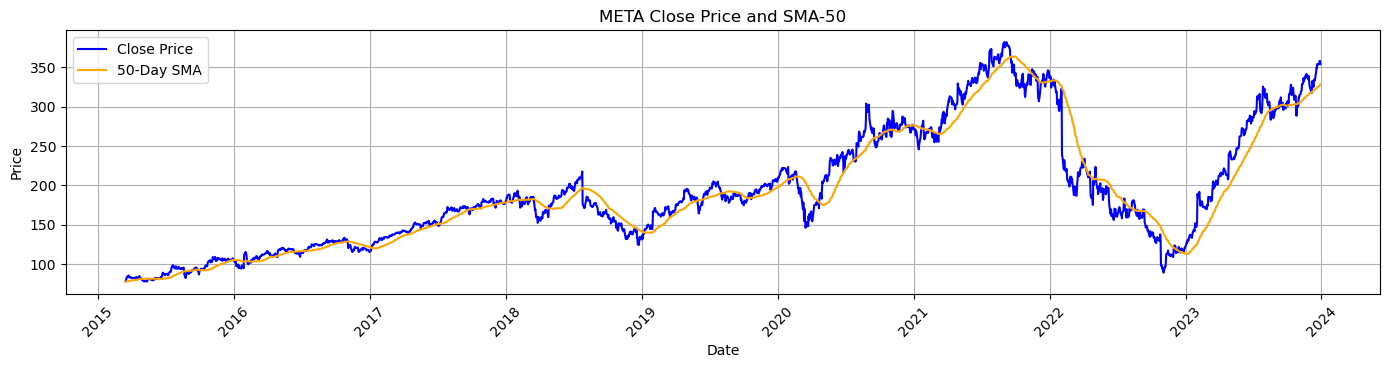

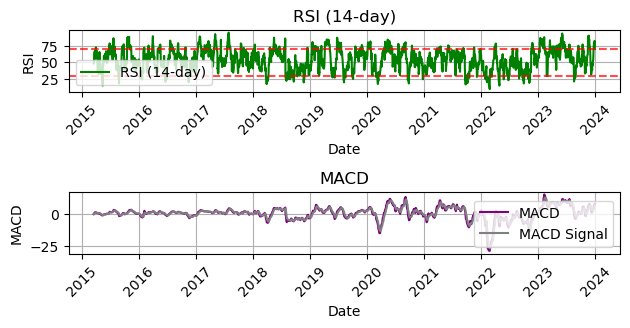

In [ ]:
# -----------------------------
# 2. Plot Raw Data and Technical Indicators
# -----------------------------
plt.figure(figsize=(14, 10))



# Now plot Close + SMA
plt.figure(figsize=(14, 10))
plt.subplot(3, 1, 1)
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.plot(df['Date'], df['SMA_50'], label='50-Day SMA', color='orange')
plt.title(f"{TICKER} Close Price and SMA-50")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot RSI
plt.subplot(3, 1, 2)
plt.plot(df['Date'], df['RSI'], label='RSI (14-day)', color='green')
plt.axhline(70, linestyle='--', color='red', alpha=0.7)
plt.axhline(30, linestyle='--', color='red', alpha=0.7)
plt.title("RSI (14-day)")
plt.xlabel("Date")
plt.ylabel("RSI")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)





# Plot MACD
plt.subplot(3, 1, 3)
plt.plot(df['Date'], df['MACD'], label='MACD', color='purple')
plt.plot(df['Date'], df['MACD_signal'], label='MACD Signal', color='gray')
plt.title("MACD")
plt.xlabel("Date")
plt.ylabel("MACD")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [12]:

# -----------------------------
# 3. Data Preparation for LSTM
# -----------------------------
# Use the following features: Close, Volume, SMA_50, RSI, MACD
features = ['Close', 'Volume', 'SMA_50', 'RSI', 'MACD']
data = df[features].values

# Scale the features to range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

def create_sequences(dataset, window_size):
    X, y = [], []
    for i in range(window_size, len(dataset)):
        X.append(dataset[i-window_size:i])
        y.append(dataset[i, 0])  # Predicting Close price (first column)
    return np.array(X), np.array(y)

WINDOW_SIZE = 60
X, y = create_sequences(scaled_data, WINDOW_SIZE)

# Split into training and testing sets (80/20 split)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test   = X[train_size:], y[train_size:]
dates_test = df['Date'].iloc[WINDOW_SIZE + train_size:].values

In [ ]:
# #improve 
# from sklearn.preprocessing import MinMaxScaler
# import numpy as np

# # -----------------------------
# # 3. Data Preparation for LSTM
# # -----------------------------

# # Select key features for LSTM
# features = ['Close', 'Volume', 'SMA_50', 'RSI', 'MACD']
# data = df[features].values

# # Scale features to [0, 1]
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(data)

# # Create sequences from scaled data
# def create_sequences(dataset, window_size, target_col_index=0):
#     X, y = [], []
#     for i in range(window_size, len(dataset)):
#         X.append(dataset[i-window_size:i])
#         y.append(dataset[i, target_col_index])  # Default: predict 'Close'
#     return np.array(X), np.array(y)

# WINDOW_SIZE = 60
# X, y = create_sequences(scaled_data, WINDOW_SIZE)

# # Train-test split (80/20)
# split_index = int(len(X) * 0.8)
# X_train, y_train = X[:split_index], y[:split_index]
# X_test, y_test   = X[split_index:], y[split_index:]

# # Preserve test dates (for plotting predictions later)
# dates_test = df['Date'].iloc[WINDOW_SIZE + split_index:].values


In [23]:

# -----------------------------
# 4. Build and Train the LSTM Model
# -----------------------------
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_split=0.1, callbacks=[early_stop], verbose=1)


Epoch 1/50


c:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - loss: 0.0705 - root_mean_squared_error: 0.2568 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0983
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0045 - root_mean_squared_error: 0.0672 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1266
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0030 - root_mean_squared_error: 0.0544 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0674
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0030 - root_mean_squared_error: 0.0549 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1025
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0029 - root_mean_squared_error: 0.0535 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0620
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0022 - root_mean_squared_error: 0.0470 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0730
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0021 - r

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dropout, Dense
# from tensorflow.keras.callbacks import EarlyStopping
# import tensorflow as tf

# # -----------------------------
# # 4. Build and Train the LSTM Model
# # -----------------------------

# # Define the model architecture
# model = Sequential([
#     LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
#     Dropout(0.2),
#     LSTM(32),
#     Dropout(0.2),
#     Dense(16, activation='relu'),
#     Dense(1)  # Predict single continuous value
# ])

# # Compile the model
# model.compile(
#     optimizer='adam',
#     loss='mse',
#     metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")]
# )

# # Early stopping to prevent overfitting
# early_stop = EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True
# )

# # Train the model
# history = model.fit(
#     X_train, y_train,
#     epochs=50,
#     batch_size=32,
#     validation_split=0.1,
#     callbacks=[early_stop],
#     verbose=1
# )


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 0.0237 - rmse: 0.1490 - val_loss: 0.0123 - val_rmse: 0.1110
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0036 - rmse: 0.0599 - val_loss: 0.0088 - val_rmse: 0.0936
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0027 - rmse: 0.0516 - val_loss: 0.0056 - val_rmse: 0.0747
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0022 - rmse: 0.0472 - val_loss: 0.0045 - val_rmse: 0.0672
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0022 - rmse: 0.0465 - val_loss: 0.0068 - val_rmse: 0.0825
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0019 - rmse: 0.0439 - val_loss: 0.0048 - val_rmse: 0.0692
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0023 - rmse: 0.0482 - val_loss: 0.0036 - val_rmse: 0.0596
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0018 - rmse: 0.0418 - val_loss: 0.0035 - val_rmse: 0.0595
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/st

In [24]:

# -----------------------------
# 5. Make Predictions and Evaluate the Model
# -----------------------------
# Predict on test set
pred_scaled = model.predict(X_test)

# To inverse transform the Close price predictions,
# we create an array with the prediction in first column and zeros for the other features,
# then apply scaler.inverse_transform, and take the first column.
dummy = np.zeros((len(pred_scaled), len(features)))
dummy[:, 0] = pred_scaled[:, 0]
predicted = scaler.inverse_transform(dummy)[:, 0]

# Do the same for true values
dummy_true = np.zeros((len(y_test), len(features)))
dummy_true[:, 0] = y_test
actual = scaler.inverse_transform(dummy_true)[:, 0]

# Calculate R-squared
r_squared = r2_score(actual, predicted)
print(f"R-squared: {r_squared:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
R-squared: 0.9776


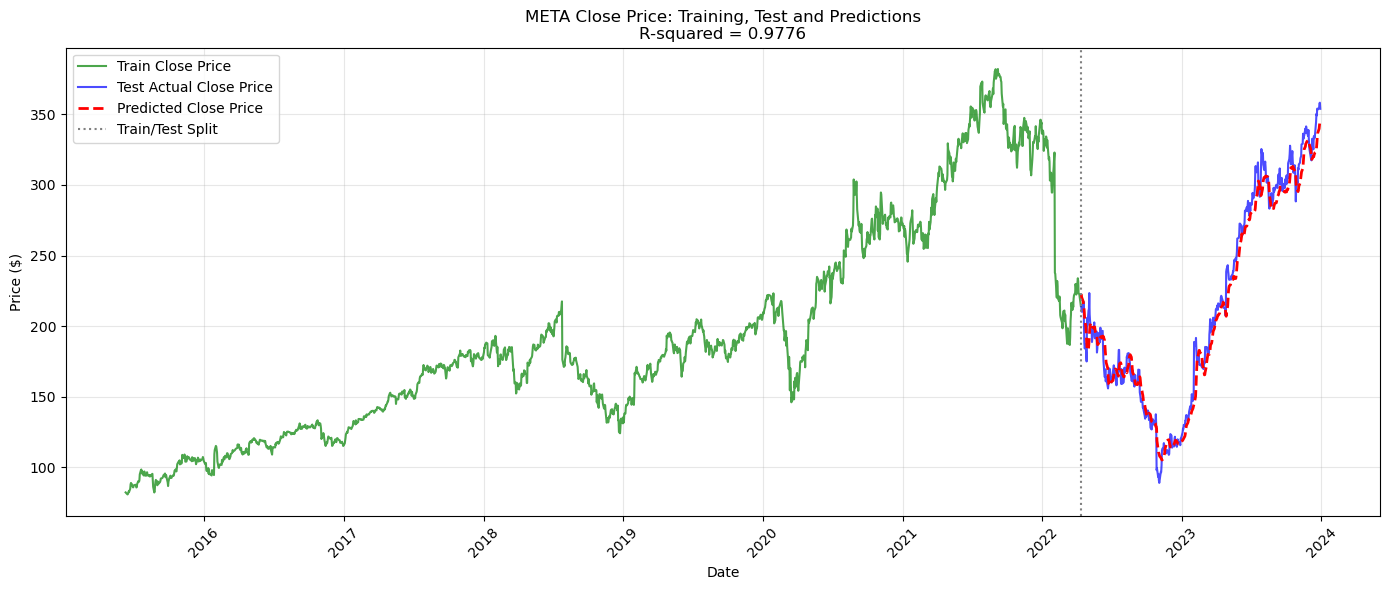

In [25]:
# -----------------------------
# 6. Plot Actual vs Predicted Close Prices (with Training Data)
# -----------------------------

# Get dates for training data (skip the first WINDOW_SIZE points used for sequences)
# dates_train = df['Date'].iloc[WINDOW_SIZE:WINDOW_SIZE + train_size].values


#improve
dates_train = df['Date'].iloc[WINDOW_SIZE:WINDOW_SIZE + len(y_train)].values


# Get actual training values (already scaled and inverse transformed)
dummy_train = np.zeros((len(y_train), len(features)))
dummy_train[:, 0] = y_train
train_actual = scaler.inverse_transform(dummy_train)[:, 0]

plt.figure(figsize=(14, 6))

# Plot training data
plt.plot(dates_train, train_actual, label='Train Close Price', color='green', alpha=0.7)

# Plot actual test data
plt.plot(dates_test, actual, label='Test Actual Close Price', color='blue', alpha=0.7)

# Plot predicted data
plt.plot(dates_test, predicted, label='Predicted Close Price', color='red', linestyle='--', linewidth=2)

# Add vertical line to show train/test split
split_date = dates_train[-1]
plt.axvline(x=split_date, color='gray', linestyle=':', label='Train/Test Split')

# Labels and formatting
plt.title(f"{TICKER} Close Price: Training, Test and Predictions\nR-squared = {r_squared:.4f}")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

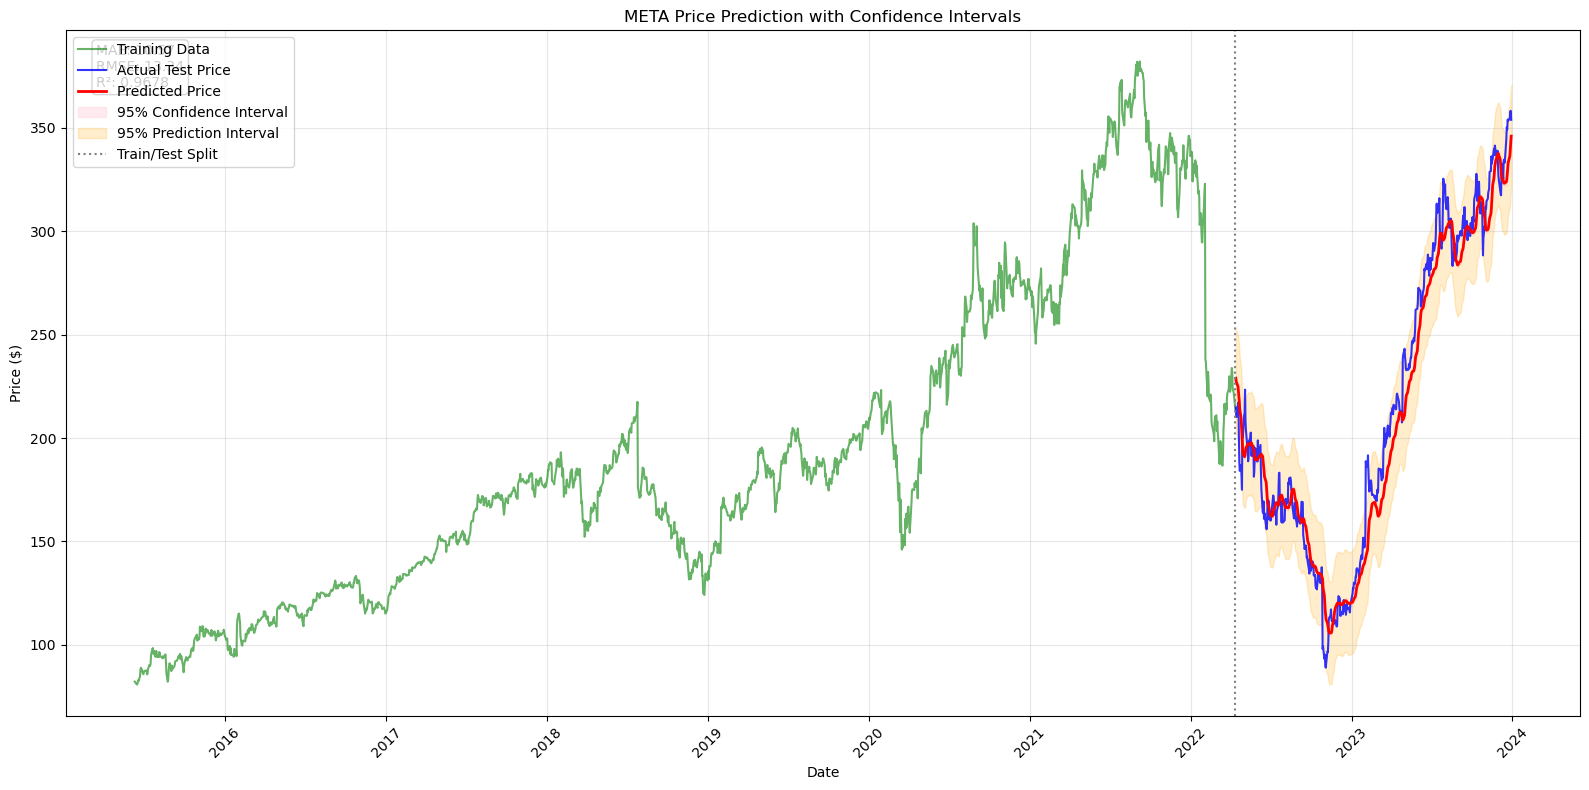

In [ ]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error

# # -----------------------------
# # Calculate Error Metrics
# # -----------------------------
# mae = mean_absolute_error(actual, predicted)
# rmse = np.sqrt(mean_squared_error(actual, predicted))

# # Calculate prediction residuals
# residuals = actual - predicted
# std_residuals = np.std(residuals)

# # Create confidence and prediction intervals
# confidence_interval = 1.96 * std_residuals / np.sqrt(len(actual))
# prediction_interval = 1.96 * std_residuals

# lower_conf = predicted - confidence_interval
# upper_conf = predicted + confidence_interval
# lower_pred = predicted - prediction_interval
# upper_pred = predicted + prediction_interval

# # -----------------------------
# # Enhanced Visualization
# # -----------------------------
# plt.figure(figsize=(16, 8))

# # Plot training data
# plt.plot(dates_train, train_actual, label='Training Data', color='green', alpha=0.6)

# # Plot test data
# plt.plot(dates_test, actual, label='Actual Test Price', color='blue', alpha=0.8)

# # Plot predictions with intervals
# plt.plot(dates_test, predicted, label='Predicted Price', color='red', linewidth=2)
# plt.fill_between(dates_test, lower_conf, upper_conf, color='pink', alpha=0.3, label='95% Confidence Interval')
# plt.fill_between(dates_test, lower_pred, upper_pred, color='orange', alpha=0.2, label='95% Prediction Interval')

# # Add error metrics to plot
# textstr = '\n'.join((
#     f'MAE: {mae:.2f}',
#     f'RMSE: {rmse:.2f}',
#     f'R²: {r_squared:.4f}'))
# props = dict(boxstyle='round', facecolor='white', alpha=0.8)
# plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes,
#         verticalalignment='top', bbox=props)

# # Add train/test split line
# split_date = dates_train[-1]
# plt.axvline(x=split_date, color='gray', linestyle=':', label='Train/Test Split')

# # Formatting
# plt.title(f"{TICKER} Price Prediction with Confidence Intervals")
# plt.xlabel("Date")
# plt.ylabel("Price ($)")
# plt.xticks(rotation=45)
# plt.legend(loc='upper left')
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

In [26]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate error metrics
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
residuals = actual - predicted
std_residuals = np.std(residuals)
avg_price = np.mean(actual)

# Calculate intervals
confidence_interval = 1.96 * std_residuals / np.sqrt(len(actual))
prediction_interval = 1.96 * std_residuals

# Generate confidence report
confidence_report = f"""
**Prediction Confidence Analysis**

1. Error Metrics:
   - Mean Absolute Error (MAE): ${mae:.2f} ({100*mae/avg_price:.1f}% of average price)
   - Root Mean Squared Error (RMSE): ${rmse:.2f}
   - Standard Deviation of Errors: ${std_residuals:.2f}

2. Prediction Intervals (95% confidence):
   - Confidence Interval (mean prediction): ±${confidence_interval:.2f}
   - Prediction Interval (individual forecasts): ±${prediction_interval:.2f}

3. Model Accuracy:
   - R² Score: {r_squared:.4f}
   - Typical Error Range: ±${mae:.2f} to ±${rmse:.2f}

**Interpretation Example**:
For a predicted closing price of $100 tomorrow:
- 95% probability the actual price will be between ${100-prediction_interval:.2f} and ${100+prediction_interval:.2f}
- The model explains {100*r_squared:.1f}% of price variability
"""

print(confidence_report)

# For next day's specific prediction (example):
next_day_pred = 150.00  # Replace with your model's actual prediction
print(f"\nExample for ${next_day_pred:.2f} prediction:")
print(f"95% confidence range: ${next_day_pred-prediction_interval:.2f} to ${next_day_pred+prediction_interval:.2f}")
print(f"Expected accuracy: ±{100*mae/avg_price:.1f}% (${mae:.2f})")


**Prediction Confidence Analysis**

1. Error Metrics:
   - Mean Absolute Error (MAE): $8.66 (4.0% of average price)
   - Root Mean Squared Error (RMSE): $11.12
   - Standard Deviation of Errors: $10.42

2. Prediction Intervals (95% confidence):
   - Confidence Interval (mean prediction): ±$0.98
   - Prediction Interval (individual forecasts): ±$20.42

3. Model Accuracy:
   - R² Score: 0.9776
   - Typical Error Range: ±$8.66 to ±$11.12

**Interpretation Example**:
For a predicted closing price of $100 tomorrow:
- 95% probability the actual price will be between $79.58 and $120.42
- The model explains 97.8% of price variability


Example for $150.00 prediction:
95% confidence range: $129.58 to $170.42
Expected accuracy: ±4.0% ($8.66)


In [27]:
# -----------------------------
# 7. Save the Model
# -----------------------------
model.save("multivariate_lstm_model.h5")

In [28]:
# Save the scaler object for use in Flask API
import joblib
joblib.dump(scaler, 'scaler.save')
print("Model and scaler saved successfully.")

Model and scaler saved successfully.
